# HW

1. use dot sizes to improve chart from homework last week.
2. use new dataset to analyze Taiwan's COVID-19 data.


In [50]:
import os
import random
import math
import json
import time
import pandas as pd
import numpy as np
import copy as copy
import matplotlib.pyplot as plt
import translators as ts
import translators.server as tss
from pandas import Timestamp
from datetime import datetime
from os import getcwd
from os.path import join
%matplotlib inline

## HW1

In [51]:
# Load World Mortality Data
path = join(getcwd().rstrip('src'),
            'data/world_mortality.csv').replace('\\', '/')
DF = pd.read_csv(path)
DF.rename(columns={'country_name': 'country'}, inplace=True)

# Separate Data by Year
DF_Regular = DF[DF.year < 2020]
DF_2020 = DF[(DF.year == 2020)]
DF_2021 = DF[(DF.year == 2021)]
DF_2022 = DF[(DF.year == 2022)]

# Data for 2015-2019
Regular = DF_Regular.groupby('country').mean().reset_index()
Regular['AverageAnnualUnitCount'] = round(Regular.time * 2 - 1, 0)
tmp = copy.copy(DF)
time_unit_dict = {'monthly': 12, 'weekly': 52}
tmp['AnnualUnitCount'] = [time_unit_dict[x] for x in tmp.time_unit]
tmp = tmp.groupby('country').mean().reset_index()[
    ['country', 'AnnualUnitCount']]
Regular = pd.merge(Regular, tmp, on='country')
Regular['deaths'] = Regular.deaths * Regular.AnnualUnitCount
Regular = Regular[['country', 'deaths', 'AverageAnnualUnitCount']]

# Data for 2020
DF_2020 = DF_2020.groupby('country').mean().reset_index()
DF_2020['AverageAnnualUnitCount'] = round(DF_2020.time * 2 - 1, 0)
DF_2020 = pd.merge(DF_2020, tmp, on='country')
DF_2020['deaths'] = DF_2020.deaths * DF_2020.AnnualUnitCount
DF_2020 = DF_2020[['country', 'deaths', 'AverageAnnualUnitCount']]

# Data for 2021
DF_2021 = DF_2021.groupby('country').mean().reset_index()
DF_2021['AverageAnnualUnitCount'] = round(DF_2021.time * 2 - 1, 0)
DF_2021 = pd.merge(DF_2021, tmp, on='country')
DF_2021['deaths'] = DF_2021.deaths * DF_2021.AnnualUnitCount
DF_2021 = DF_2021[['country', 'deaths', 'AverageAnnualUnitCount']]

# Data for 2022
DF_2022 = DF_2022.groupby('country').mean().reset_index()
DF_2022['AverageAnnualUnitCount'] = round(DF_2022.time * 2 - 1, 0)
DF_2022 = pd.merge(DF_2022, tmp, on='country')
DF_2022['deaths'] = DF_2022.deaths * DF_2022.AnnualUnitCount
DF_2022 = DF_2022[['country', 'deaths', 'AverageAnnualUnitCount']]

# Merge Data (2015-2019, 2020, 2021, 2022)
newDF = pd.concat([Regular, DF_2020[['deaths']],
                  DF_2021[['deaths']], DF_2022[['deaths']]], axis=1)
newDF.columns = ['country', 'RegularDeaths',
                 'RegularAverageAnnualUnitCount', '2020Deaths', '2021Deaths', '2022Deaths']
newDF = newDF.reindex(['country', 'RegularAverageAnnualUnitCount', 'RegularDeaths',
                       '2020Deaths', '2021Deaths', '2022Deaths'], axis='columns')

# Excess Deaths (2020, 2021, 2022)
EXD2020 = newDF['2020Deaths'] - newDF['RegularDeaths']
EXD2020.rename('EXD2020', inplace=True)
EXD2021 = newDF['2021Deaths'] - newDF['RegularDeaths']
EXD2021.rename('EXD2021', inplace=True)
EXD2022 = newDF['2022Deaths'] - newDF['RegularDeaths']
EXD2022.rename('EXD2022', inplace=True)
newDF = pd.concat([newDF, EXD2020, EXD2021, EXD2022], axis=1)
newDF.rename(columns={'RegularAverageAnnualUnitCount': 'RAAUC'}, inplace=True)

# Merge with OWID Population Data
path = join(getcwd().rstrip('src'),
            'data/owid-covid-data.csv').replace('\\', '/')
data = pd.read_csv(path)
data = data[['location', 'population']]
data.rename(columns={'location': 'country'}, inplace=True)
data.groupby('country').count().sort_values(by='population', ascending=False)
data.drop_duplicates(subset=['country'], inplace=True)
data.reset_index(drop=True, inplace=True)
con1 = list(data.country)
con2 = list(newDF.country)
pop = []
for c in con2:
    if c in con1:
        pop.append(data[data.country == c].population.values[0])
    else:
        pop.append(0)
pop = pd.Series(pop, name='population')
newDF = pd.concat([newDF['country'], newDF['RAAUC'], pop, newDF['RegularDeaths'], newDF['2020Deaths'],
                  newDF['2021Deaths'], newDF['2022Deaths'], newDF['EXD2020'], newDF['EXD2021'], newDF['EXD2022']], axis=1)

# Excess Deaths per Million (2020, 2021, 2022)
RDPP = newDF['RegularDeaths'] / newDF['population'] * 1000000
RDPP.rename('RDBP', inplace=True)  # Regular Deaths by Population Percentage
IDPP2020 = newDF['2020Deaths'] / newDF['population'] * 1000000
# Irregular Deaths by Population in Percentage in 2020
IDPP2020.rename('IDPP2020', inplace=True)
IDPP2021 = newDF['2021Deaths'] / newDF['population'] * 1000000
# Irregular Deaths by Population in Percentage in 2021
IDPP2021.rename('IDPP2021', inplace=True)
IDPP2022 = newDF['2022Deaths'] / newDF['population'] * 1000000
# Irregular Deaths by Population in Percentage in 2022
IDPP2022.rename('IDPP2022', inplace=True)
EDPP2020 = newDF['EXD2020'] / newDF['population'] * 1000000
# Excess Deaths by Population in Percentage in 2020
EDPP2020.rename('EDPP2020', inplace=True)
EDPP2021 = newDF['EXD2021'] / newDF['population'] * 1000000
# Excess Deaths by Population in Percentage in 2021
EDPP2021.rename('EDPP2021', inplace=True)
EDPP2022 = newDF['EXD2022'] / newDF['population'] * 1000000
# Excess Deaths by Population in Percentage in 2022
EDPP2022.rename('EDPP2022', inplace=True)
newDF = pd.concat([newDF, RDPP, IDPP2020, IDPP2021,
                  IDPP2022, EDPP2020, EDPP2021, EDPP2022], axis=1)

# Export Data
newDF.to_csv(join(getcwd().rstrip('src'),
                  'data/bd_w13_hw/table.csv').replace('\\', '/'), sep=';', index=False)

# Show Data
newDF.head()


C:\Users\dachu\AppData\Local\Temp\ipykernel_16652\2366282377.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  Regular = DF_Regular.groupby('country').mean().reset_index()
C:\Users\dachu\AppData\Local\Temp\ipykernel_16652\2366282377.py:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  tmp = tmp.groupby('country').mean().reset_index()[
C:\Users\dachu\AppData\Local\Temp\ipykernel_16652\2366282377.py:26: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which sho

,country,RAAUC,population,RegularDeaths,2020Deaths,2021Deaths,2022Deaths,EXD2020,EXD2021,EXD2022,RDBP,IDPP2020,IDPP2021,IDPP2022,EDPP2020,EDPP2021,EDPP2022
0,Albania,12.0,2854710.0,21955.80,27605.0,30580.0,25708.000000,5649.20,8624.20,3752.200000,7691.078954,9669.983991,10712.121371,9.005468e+03,1978.905038,3021.042418,1.314389e+03
1,Algeria,12.0,44177969.0,179289.65,235628.0,649.0,27462.666667,56338.35,-178640.65,-151826.983333,4058.349763,5333.608704,14.690580,6.216371e+02,1275.258942,-4043.659182,-3.436713e+03
2,Andorra,12.0,79034.0,310.20,419.0,34638.0,190732.533333,108.80,34327.80,190422.333333,3924.893084,5301.515803,438267.074930,2.413297e+06,1376.622719,434342.181846,2.409372e+06
3,Antigua and Barbuda,12.0,93220.0,570.60,574.0,964.0,89276.571429,3.40,393.40,88705.971429,6121.004076,6157.476936,10341.128513,9.576976e+05,36.472860,4220.124437,9.515766e+05
4,Argentina,12.0,45276780.0,341388.60,376221.0,170960.0,62637.000000,34832.40,-170428.60,-278751.600000,7540.037079,8309.358572,3775.886889,1.383424e+03,769.321493,-3764.150189,-6.156613e+03


### Add X & Y axis

In [52]:
# X = newDF['EXD2020'] + newDF['EXD2021']
X = newDF['EDPP2020'] + newDF['EDPP2021']
X.rename('X', inplace=True)
# Y = newDF['EXD2022'] / X
Y = newDF['EDPP2022'] / X
Y.rename('Y', inplace=True)
newDF = pd.concat([newDF, X, Y], axis=1)
newDF.head()

,country,RAAUC,population,RegularDeaths,2020Deaths,2021Deaths,2022Deaths,EXD2020,EXD2021,EXD2022,RDBP,IDPP2020,IDPP2021,IDPP2022,EDPP2020,EDPP2021,EDPP2022,X,Y
0,Albania,12.0,2854710.0,21955.80,27605.0,30580.0,25708.000000,5649.20,8624.20,3752.200000,7691.078954,9669.983991,10712.121371,9.005468e+03,1978.905038,3021.042418,1.314389e+03,4999.947455,0.262881
1,Algeria,12.0,44177969.0,179289.65,235628.0,649.0,27462.666667,56338.35,-178640.65,-151826.983333,4058.349763,5333.608704,14.690580,6.216371e+02,1275.258942,-4043.659182,-3.436713e+03,-2768.400240,1.241407
2,Andorra,12.0,79034.0,310.20,419.0,34638.0,190732.533333,108.80,34327.80,190422.333333,3924.893084,5301.515803,438267.074930,2.413297e+06,1376.622719,434342.181846,2.409372e+06,435718.804565,5.529650
3,Antigua and Barbuda,12.0,93220.0,570.60,574.0,964.0,89276.571429,3.40,393.40,88705.971429,6121.004076,6157.476936,10341.128513,9.576976e+05,36.472860,4220.124437,9.515766e+05,4256.597297,223.553355
4,Argentina,12.0,45276780.0,341388.60,376221.0,170960.0,62637.000000,34832.40,-170428.60,-278751.600000,7540.037079,8309.358572,3775.886889,1.383424e+03,769.321493,-3764.150189,-6.156613e+03,-2994.828696,2.055748


(0.0, 3.5)

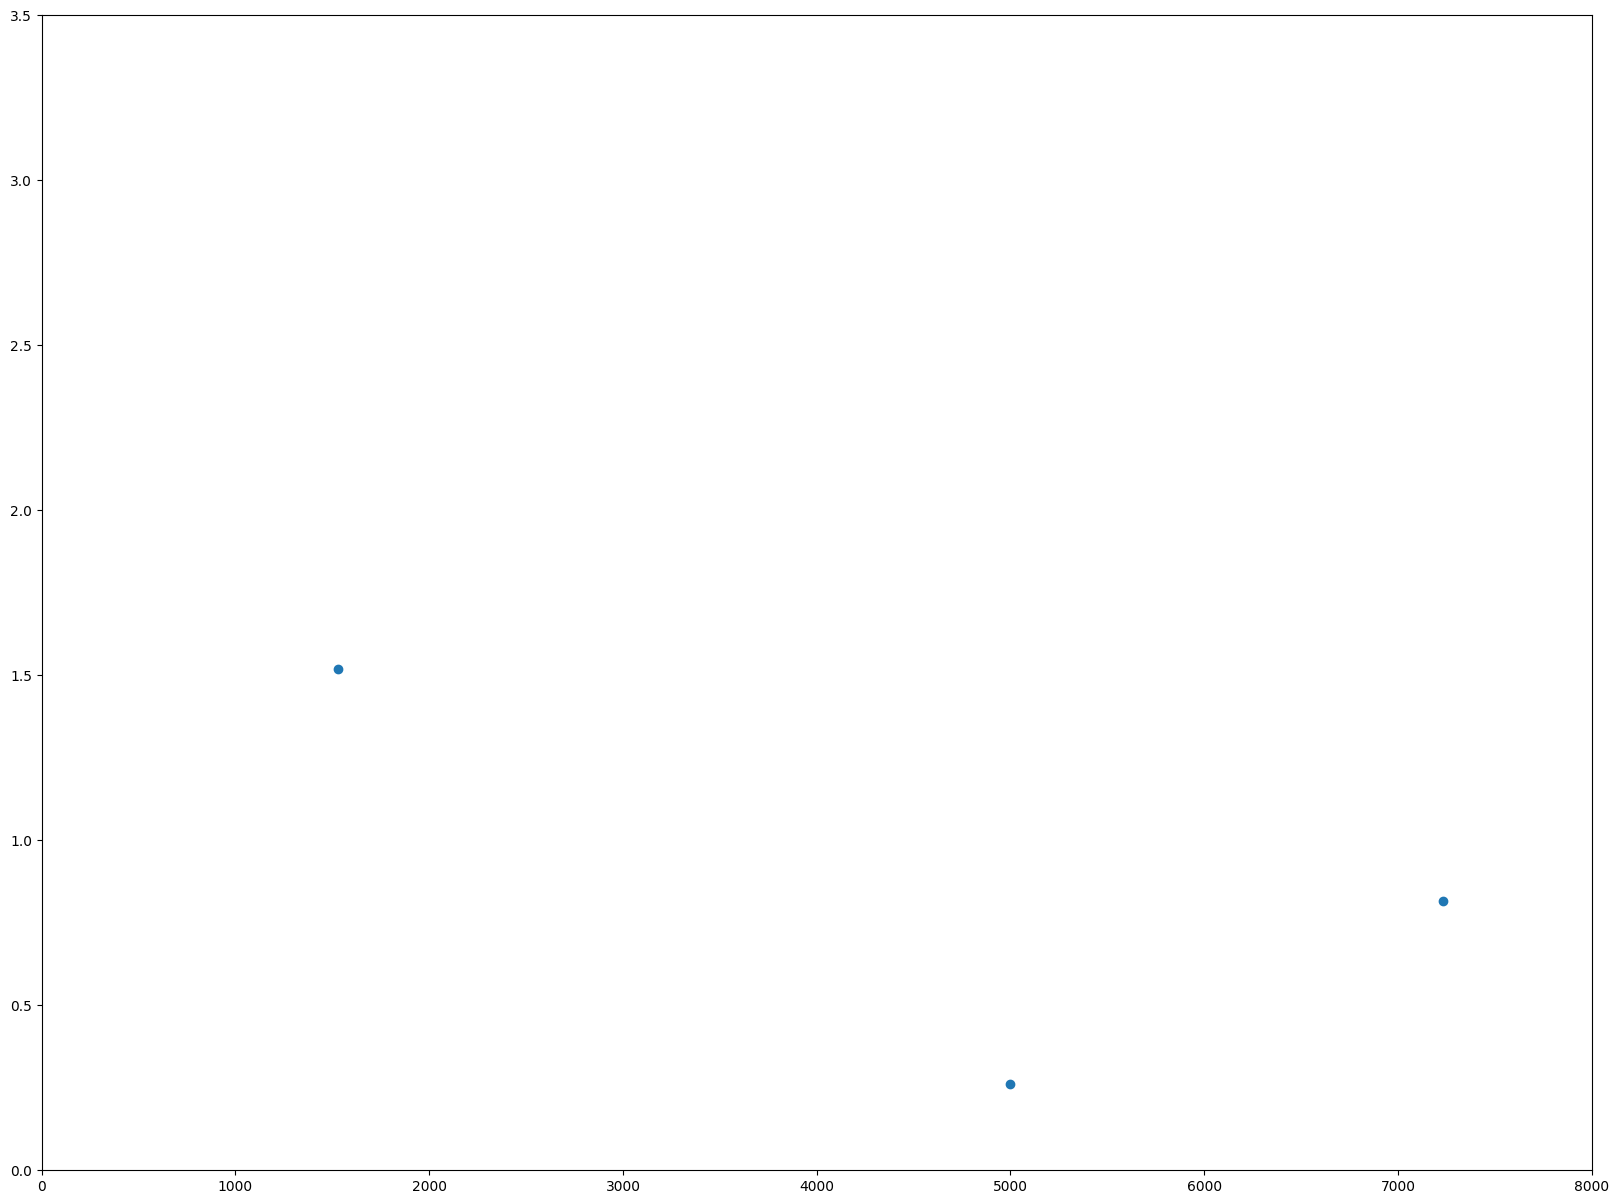

In [53]:
plt.figure(figsize=(20, 15))
plt.scatter(newDF['X'], newDF['Y'])
plt.xlim(0, 8000)
plt.ylim(0, 3.5)

### Result

I still fail to recreate the data presented in video.
It looks like the data processing procedure is different and created largely different result.

## HW2

### Read and Combine Datasets

In [54]:
data_path_1 = os.path.join(
    os.getcwd().rstrip('src'), 'data', 'TaiwanDeathDetail2021.xlsx')
data_path_2 = os.path.join(
    os.getcwd().rstrip('src'), 'data', 'TaiwanDeathDetail20220611.xlsx')
data1 = pd.read_excel(data_path_1, sheet_name='TaiwanDeathDetail2021.csv')
data2 = pd.read_excel(data_path_2, sheet_name='TaiwanDeathDetail20220611.csv')
data = pd.concat([data1, data2], axis=0)
print(data.shape)
data.head()


(3981, 15)


,公布日,案號,性別,年齡,慢性病史,活動接觸史,發病日,症狀,採檢日,住院/隔離日,確診日,死亡日,日期,是否接種COVID19疫苗,住院／隔離日
0,2022-12-19,4397.0,男,60多歲,有,無,2022-05-22 00:00:00,發燒,2022-05-22 00:00:00,2022-05-23 00:00:00,2022-05-24 00:00:00,2022-12-01 00:00:00,NaT,NaN,NaN
1,2022-12-15,10511.0,男,50多歲,有,有,2022-06-03 00:00:00,呼吸喘,2022-06-03 00:00:00,6/4住院，8月14日解除隔離,2022-06-05 00:00:00,2022-11-19 00:00:00,NaT,NaN,NaN
2,2022-11-09,8724.0,女,90多歲,有,有,2022-05-24 00:00:00,發燒、喉嚨痛,2022-05-31 00:00:00,5/30住院、\n7/26解除隔離,2022-06-01 00:00:00,2022-10-11 00:00:00,NaT,NaN,NaN
3,2022-10-25,12235.0,男,80多歲,有,接觸其他確診者,2022-06-08 00:00:00,食慾不振、昏睡,2022-06-08 00:00:00,6/8\n7/14解除隔離,2022-06-10 00:00:00,2022-10-22 00:00:00,NaT,NaN,NaN
4,2022-10-09,8748.0,女,70多歲,有,接觸其他確診者,--,--,2022-05-30 00:00:00,5/31住院\n9/17解除隔離,2022-06-01 00:00:00,2022-10-04 00:00:00,NaT,NaN,NaN


### Convert Mandarin Content to English

#### Test Google API

In [55]:
# https://pypi.org/project/translators/
print(ts.translators_pool)
print(ts.translate_text('我是一個人'))
print(tss.google('食慾不振、昏睡', from_language='zh', to_language='en'))


['alibaba', 'argos', 'baidu', 'bing', 'caiyun', 'deepl', 'google', 'iciba', 'iflytek', 'itranslate', 'lingvanex', 'niutrans', 'mglip', 'papago', 'reverso', 'sogou', 'tencent', 'translateCom', 'utibet', 'yandex', 'youdao']
I am alone
Lost appetite, lethargy


#### Test Baidu (Professional Field)
('common','medicine','electronics','mechanics')

In [57]:
# super unstable
# print(tss.baidu('食慾不振、昏睡', professional_field='medicine'))

#### Rename columns

In [69]:
# flatten dynamic dimension list
def flatten(lis):
    def flat(lis):
        for element in lis:
            if isinstance(element, list):
                flat(element)
            else:
                return_lis.append(element)
    return_lis = []
    flat(lis)
    return return_lis



In [86]:
def translate(lis):
    return_lis = []
    for element in lis:
        temp = tss.google(element, from_language='zh', to_language='en')
        temp = temp.lower()
        return_lis.append(temp)
    return return_lis

In [70]:
# replace '／' with '/'
columns = data.columns.to_list()
columns_tmp = []
for element in columns:
    if '／' in element:
        element = element.replace('／', '/')
    columns_tmp.append(element)
columns = columns_tmp

In [87]:
# translate
columns_ts = translate(columns)


In [88]:
# rename columns
print(columns)
print(columns_ts)
data.columns = columns_ts
data.head()

['公布日', '案號', '性別', '年齡', '慢性病史', '活動接觸史', '發病日', '症狀', '採檢日', '住院/隔離日', '確診日', '死亡日', '日期', '是否接種COVID19疫苗', '住院/隔離日']
['announcement day', 'case number', 'gender', 'age', 'chronic medical history', 'activity contact history', 'onset day', 'symptom', 'admission day', 'inpatient/isolation day', 'diagnosis day', 'death day', 'date', 'whether to vaccinate the covid19 vaccine', 'inpatient/isolation day']


,announcement day,case number,gender,age,chronic medical history,activity contact history,onset day,symptom,admission day,inpatient/isolation day,diagnosis day,death day,date,whether to vaccinate the covid19 vaccine,inpatient/isolation day
0,2022-12-19,4397.0,男,60多歲,有,無,2022-05-22 00:00:00,發燒,2022-05-22 00:00:00,2022-05-23 00:00:00,2022-05-24 00:00:00,2022-12-01 00:00:00,NaT,NaN,NaN
1,2022-12-15,10511.0,男,50多歲,有,有,2022-06-03 00:00:00,呼吸喘,2022-06-03 00:00:00,6/4住院，8月14日解除隔離,2022-06-05 00:00:00,2022-11-19 00:00:00,NaT,NaN,NaN
2,2022-11-09,8724.0,女,90多歲,有,有,2022-05-24 00:00:00,發燒、喉嚨痛,2022-05-31 00:00:00,5/30住院、\n7/26解除隔離,2022-06-01 00:00:00,2022-10-11 00:00:00,NaT,NaN,NaN
3,2022-10-25,12235.0,男,80多歲,有,接觸其他確診者,2022-06-08 00:00:00,食慾不振、昏睡,2022-06-08 00:00:00,6/8\n7/14解除隔離,2022-06-10 00:00:00,2022-10-22 00:00:00,NaT,NaN,NaN
4,2022-10-09,8748.0,女,70多歲,有,接觸其他確診者,--,--,2022-05-30 00:00:00,5/31住院\n9/17解除隔離,2022-06-01 00:00:00,2022-10-04 00:00:00,NaT,NaN,NaN


#### Translate Column 'gender'

In [89]:
genders = data['gender'].unique().tolist()
print(genders)
genders_ts = translate(genders)
print(genders_ts)


['男', '女']
['male', 'female']


In [92]:
map_dict = dict(zip(genders, genders_ts))
print(map_dict)
data['gender'] = data['gender'].map(map_dict)
data.head()

{'男': 'male', '女': 'female'}


,announcement day,case number,gender,age,chronic medical history,activity contact history,onset day,symptom,admission day,inpatient/isolation day,diagnosis day,death day,date,whether to vaccinate the covid19 vaccine,inpatient/isolation day
0,2022-12-19,4397.0,male,60多歲,有,無,2022-05-22 00:00:00,發燒,2022-05-22 00:00:00,2022-05-23 00:00:00,2022-05-24 00:00:00,2022-12-01 00:00:00,NaT,NaN,NaN
1,2022-12-15,10511.0,male,50多歲,有,有,2022-06-03 00:00:00,呼吸喘,2022-06-03 00:00:00,6/4住院，8月14日解除隔離,2022-06-05 00:00:00,2022-11-19 00:00:00,NaT,NaN,NaN
2,2022-11-09,8724.0,female,90多歲,有,有,2022-05-24 00:00:00,發燒、喉嚨痛,2022-05-31 00:00:00,5/30住院、\n7/26解除隔離,2022-06-01 00:00:00,2022-10-11 00:00:00,NaT,NaN,NaN
3,2022-10-25,12235.0,male,80多歲,有,接觸其他確診者,2022-06-08 00:00:00,食慾不振、昏睡,2022-06-08 00:00:00,6/8\n7/14解除隔離,2022-06-10 00:00:00,2022-10-22 00:00:00,NaT,NaN,NaN
4,2022-10-09,8748.0,female,70多歲,有,接觸其他確診者,--,--,2022-05-30 00:00:00,5/31住院\n9/17解除隔離,2022-06-01 00:00:00,2022-10-04 00:00:00,NaT,NaN,NaN
